In [1]:
%matplotlib inline
import numpy as np
import time
import keras
import pandas as pd
import math
import joblib
import matplotlib.pyplot as plt

from random import randint

from IPython.display import display

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, Dropout, Conv2D, Conv2DTranspose
from keras.engine import Layer
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model, Sequential
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import mnist
from tqdm import tnrange, tqdm_notebook

Using TensorFlow backend.


In [2]:
img_rows, img_cols, img_chns = 28, 28, 1
original_img_size = (img_rows, img_cols, img_chns)
batch_size = 500
epochs = 1000
hidden_units = 8000
hidden_layers = 2
learning_rate = 0.0005
dropout = 0.1

# Binarized MNIST

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.round(X_train.reshape(X_train.shape[0], img_rows * img_cols) / 255.)
X_test = np.round(X_test.reshape(X_test.shape[0], img_rows * img_cols) / 255.)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


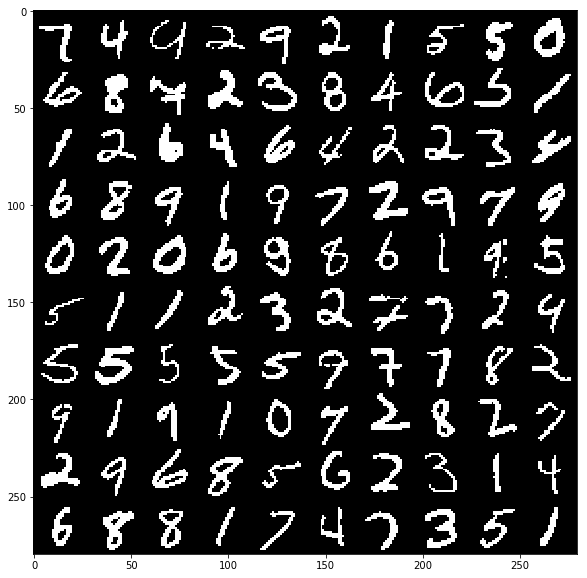

In [4]:
def display_digits(X, digit_size=28, n=10):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for i in range(n):
        for j in range(n):
            index = np.random.randint(0, X.shape[0])
            digit = X[index].reshape(digit_size, digit_size)
            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = digit
    
    plt.figure(figsize=(n, n))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    
display_digits(X_train)

# Custom Layer for MADE masking

In [5]:
# from keras.layers import activations
from keras.layers import initializers
from keras.layers import activations
from keras.layers import regularizers
from keras.layers import constraints
from keras.engine import InputSpec

class MaskingDense(Layer):
    """ Just copied code from keras Dense layer and added masking """

    def __init__(self, units, out_units,
                 hidden_layers=1,
                 dropout_rate=0.0,
                 random_input_order=False,
                 activation='relu',
                 out_activation='sigmoid',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(MaskingDense, self).__init__(**kwargs)
        
        self.input_sel = None
        self.random_input_order = random_input_order
        self.rate = min(1., max(0., dropout_rate))
        self.kernel_sels = []
        self.units = units
        self.out_units = out_units
        self.hidden_layers = hidden_layers
        self.activation = activations.get(activation)
        self.out_activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        
    def dropout_wrapper(self, inputs, training):
        if 0. < self.rate < 1.:
            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape=None, seed=None)
            return K.in_train_phase(dropped_inputs, inputs,
                                    training=training)
        
        return inputs
        
    def build_layer_weights(self, input_dim, units, use_bias=True):
        kernel = self.add_weight(shape=(input_dim, units),
                                 initializer=self.kernel_initializer,
                                 name='kernel',
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)
     
        if use_bias:
            bias = self.add_weight(shape=(units,),
                                   initializer=self.bias_initializer,
                                   name='bias',
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        else:
            bias = None
        
        return kernel, bias
    
    def build_mask(self, shape, prev_sel, is_output):
        if is_output:
            input_sel = self.input_sel
        else:
            # Disallow D-1 because it would violate auto-regressive property
            # Disallow 0 because it would just createa a constant node
            # Disallow unconnected units by sampling min from previous layer
            input_sel = [randint(np.min(prev_sel), shape[-1] - 2) for i in range(shape[-1])]
            
        def vals():
            for x in range(shape[-2]):
                for y in range(shape[-1]):
                    if is_output:
                        yield 1 if prev_sel[x] < input_sel[y] else 0
                    else:
                        yield 1 if prev_sel[x] <= input_sel[y] else 0
        
        return K.constant(list(vals()), dtype='float32', shape=shape), input_sel
        
    def build(self, input_shape):
        assert len(input_shape) >= 2
           
        self.kernels, self.biases = [], []
        self.kernel_masks, self.kernel_sels = [], []
        shape = (input_shape[-1], self.units)
       
        self.input_sel = np.arange(input_shape[-1])
        if self.random_input_order:
            np.random.shuffle(self.input_sel)
        prev_sel = self.input_sel
        for x in range(self.hidden_layers):
            # Hidden layer
            kernel, bias = self.build_layer_weights(*shape)
            self.kernels.append(kernel)
            self.biases.append(bias)
            
            # Hidden layer mask
            kernel_mask, kernel_sel = self.build_mask(shape, prev_sel, is_output=False)
            self.kernel_masks.append(kernel_mask)
            self.kernel_sels.append(kernel_sel)
        
            prev_sel = kernel_sel
            shape = (self.units, self.units)
            
        # Direct connection between input/output
        direct_shape = (input_shape[-1], self.out_units)
        self.direct_kernel, _ = self.build_layer_weights(*direct_shape, use_bias=False)
        self.direct_kernel_mask, self.direct_sel = self.build_mask(direct_shape, self.input_sel, is_output=True)
        
        # Output layer
        out_shape = (self.units, self.out_units)
        self.out_kernel, self.out_bias = self.build_layer_weights(*out_shape)
        self.out_kernel_mask, self.out_sel = self.build_mask(out_shape, prev_sel, is_output=True)
        
        self.built = True

    def call(self, inputs, training=None):
        # Hidden layer + mask
        output = inputs
        for i in range(self.hidden_layers):
            weight = self.kernels[i] * self.kernel_masks[i]
            output = K.dot(output, weight)
            output = K.bias_add(output, self.biases[i])
            output = self.activation(output)
            output = self.dropout_wrapper(output, training)
       
        # Direct connection
        direct = K.dot(inputs, self.direct_kernel * self.direct_kernel_mask)
        direct = self.dropout_wrapper(direct, training)
        
        # out_act(bias + (V dot M_v)h(x) + (A dot M_v)x) 
        output = K.dot(output, self.out_kernel * self.out_kernel_mask)
        output = output + direct
        output = K.bias_add(output, self.out_bias)
        output = self.out_activation(output)
        
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.out_units)

In [6]:
def logx_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean)
    return xent_loss

In [7]:
K.set_learning_phase(1)
        
main_input = Input(shape=(img_rows * img_cols,), name='main_input')
mask_1 = MaskingDense(hidden_units, img_rows * img_cols, 
                      hidden_layers=hidden_layers,
                      dropout_rate=dropout,
                      random_input_order=False)(main_input)

model = Model(inputs=main_input, outputs=mask_1)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=logx_loss)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 784)               0         
_________________________________________________________________
masking_dense_1 (MaskingDens (None, 784)               77175440  
Total params: 77,175,440
Trainable params: 77,175,440
Non-trainable params: 0
_________________________________________________________________


In [8]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=0.1, patience=50)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, min_lr=0.001 * learning_rate)

history = model.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],
    validation_data=(X_test, X_test),
    verbose=0
)

K.set_learning_phase(0)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  10180.555913209915


,loss,lr,val_loss
count,617.000000,617.000000,617.000000
mean,101.471964,0.000210,105.805360
std,15.725137,0.000168,11.208824
min,92.003371,0.000016,98.788699
0%,92.003371,0.000016,98.788699
25%,93.487519,0.000063,99.750697
50%,96.018039,0.000125,101.309906
75%,103.357094,0.000250,106.639875
95%,121.922096,0.000500,123.638572
99%,155.712934,0.000500,152.594302


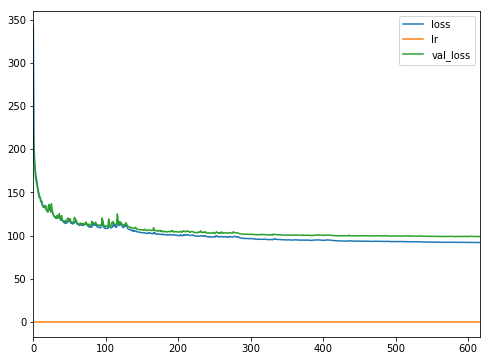

In [9]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

In [10]:
def gen_image(model, num_samples=10):
    x_sample = np.random.rand(num_samples, img_rows * img_cols)
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(0, img_rows * img_cols):
        x_out = model.predict(x_sample)
            
        p = np.random.rand(num_samples)
        index = model.layers[-1].input_sel[i]
        x_sample[:, index] = (x_out[:, index] > p).astype(float)
        
    return x_sample

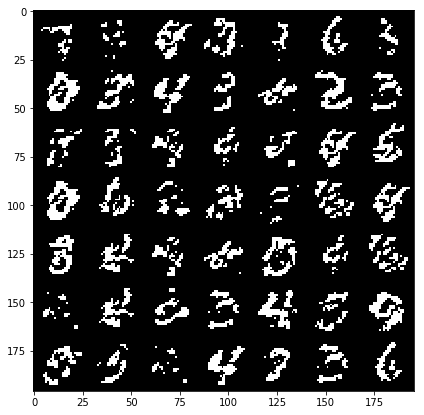

Elapsed:  23.384340286254883


In [11]:
start = time.time()

K.set_learning_phase(0)
x_sample = gen_image(model, num_samples=100)

display_digits(x_sample, n=7)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)